# ノートブック04: 線形モデル - シンプルだが強力な武器 📈

**学習目標**: 線形モデルの基礎から実践まで、Ridge/Lasso/ElasticNetを完全にマスターする

---

## 📋 このノートブックで学ぶこと

### 1. 線形回帰の基礎 ⭐⭐⭐
- 最小二乗法の仕組み
- 係数の解釈
- 決定係数（R²）の意味
- 残差分析

### 2. 正則化の重要性 ⭐⭐⭐
- 過学習とは何か
- Ridge回帰（L2正則化）
- Lasso回帰（L1正則化）
- ElasticNet（L1+L2）

### 3. ハイパーパラメータチューニング ⭐⭐
- αパラメータの選択
- Cross-Validationによる最適化
- 正則化パスの可視化

### 4. 実践的な応用 ⭐⭐⭐
- 住宅価格予測
- 特徴量の標準化
- モデルの比較と選択

---

## 🎯 達成目標

このノートブックを完了すると：
- ✅ 線形回帰の仕組みを完全に理解できる
- ✅ Ridge/Lasso/ElasticNetを使い分けられる
- ✅ 正則化パラメータを適切に調整できる
- ✅ 実データで線形モデルを適用できる

---

## 📚 前提知識

- Python基礎
- NumPy、Pandas の基本操作
- 基本的な統計（平均、分散）

⏱️ **推定学習時間**: 120-150分  
📊 **難易度**: ★★★☆☆（中級）

---

## 🔧 1. セットアップ

In [1]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# 機械学習
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    ElasticNet,
    RidgeCV,
    LassoCV
)
from sklearn.datasets import make_regression, fetch_california_housing

# 設定
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# 再現性のためのシード
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ セットアップ完了")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ セットアップ完了
NumPy version: 2.3.5
Pandas version: 2.3.3


## 📊 2. 線形回帰の基礎

### 線形回帰とは？

線形回帰は、入力変数（特徴量）と出力変数（目的変数）の関係を**直線**でモデル化する手法です。

**数式**:  
$$y = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$$

- $y$: 予測値
- $w_0$: 切片（bias）
- $w_1, w_2, ..., w_n$: 係数（weights）
- $x_1, x_2, ..., x_n$: 特徴量

### 最小二乗法

係数を決定するため、**残差の二乗和を最小化**します：

$$\min_{w} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

### 2.1 シンプルな例：1変数の線形回帰

📊 学習結果:
   真の係数: w1=2.0, w0=1.0
   学習した係数: w1=2.028, w0=0.654
   R² Score: 0.915
   RMSE: 1.805


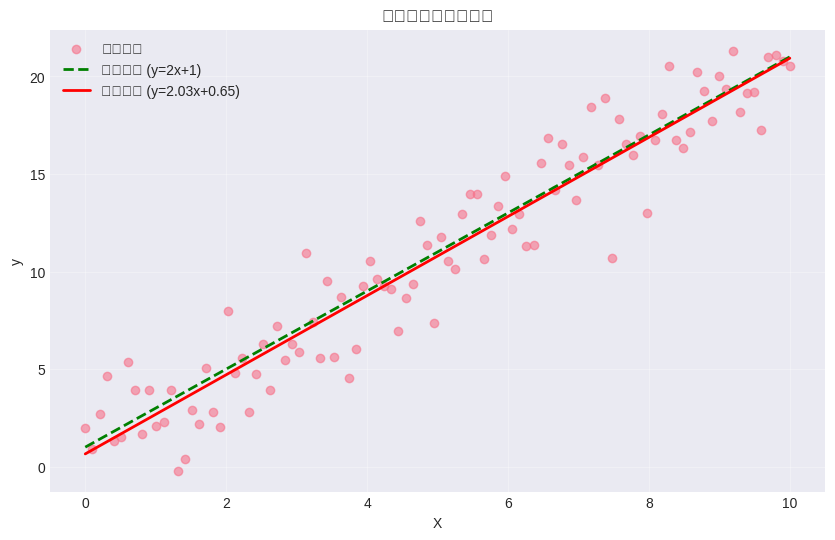

In [2]:
# シンプルなデータ生成: y = 2x + 1 + ノイズ
np.random.seed(RANDOM_STATE)
n_samples = 100

# 真の関係: y = 2x + 1
X_simple = np.linspace(0, 10, n_samples).reshape(-1, 1)
y_true = 2 * X_simple.ravel() + 1
y_simple = y_true + np.random.randn(n_samples) * 2  # ノイズを追加

# 線形回帰モデルの訓練
model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)

# 予測
y_pred = model_simple.predict(X_simple)

# 結果の表示
print("📊 学習結果:")
print(f"   真の係数: w1=2.0, w0=1.0")
print(f"   学習した係数: w1={model_simple.coef_[0]:.3f}, w0={model_simple.intercept_:.3f}")
print(f"   R² Score: {r2_score(y_simple, y_pred):.3f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_simple, y_pred)):.3f}")

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_simple, y_simple, alpha=0.6, label='データ点')
ax.plot(X_simple, y_true, 'g--', linewidth=2, label='真の直線 (y=2x+1)')
ax.plot(X_simple, y_pred, 'r-', linewidth=2, label=f'予測直線 (y={model_simple.coef_[0]:.2f}x+{model_simple.intercept_:.2f})')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('シンプルな線形回帰')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### 2.2 残差分析 ⭐⭐⭐

残差（residuals）は、実測値と予測値の差です：

$$\text{residual} = y_{\text{actual}} - y_{\text{predicted}}$$

良いモデルの残差は：
- 平均が0に近い
- ランダムに分布している
- 特定のパターンがない

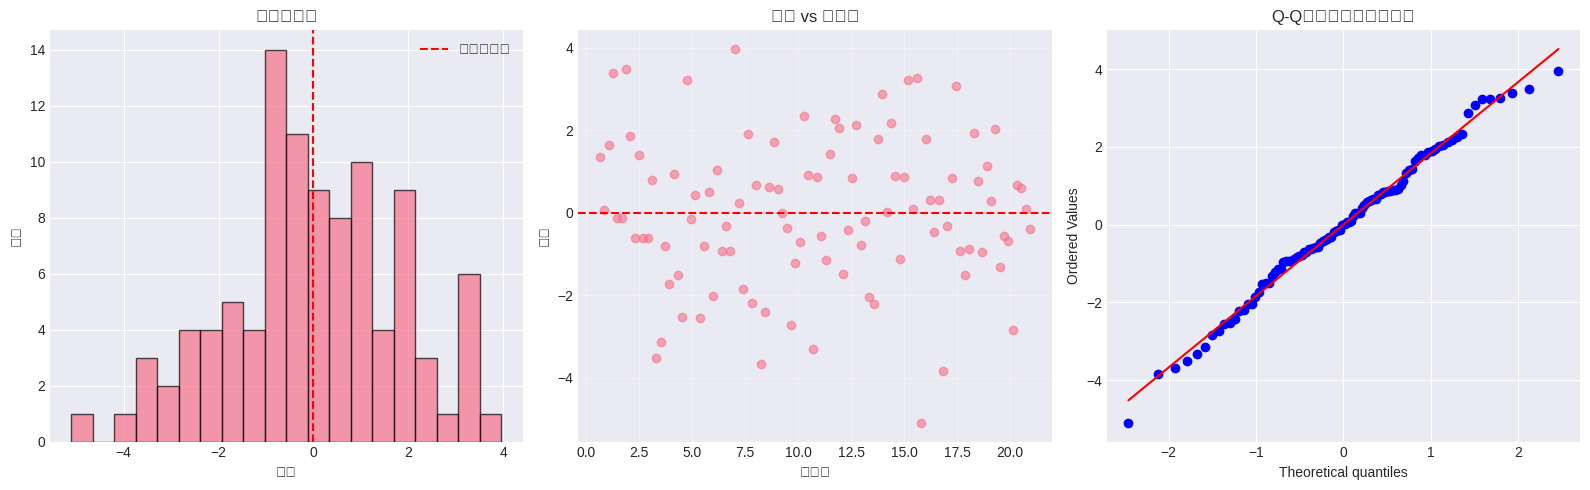


📊 残差統計:
   平均: -0.000000
   標準偏差: 1.805
   最小値: -5.100
   最大値: 3.964


In [3]:
# 残差の計算
residuals = y_simple - y_pred

# 残差分析の可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. 残差のヒストグラム
axes[0].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', label='ゼロライン')
axes[0].set_xlabel('残差')
axes[0].set_ylabel('頻度')
axes[0].set_title('残差の分布')
axes[0].legend()

# 2. 残差 vs 予測値
axes[1].scatter(y_pred, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('予測値')
axes[1].set_ylabel('残差')
axes[1].set_title('残差 vs 予測値')
axes[1].grid(True, alpha=0.3)

# 3. Q-Qプロット（正規性の確認）
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Qプロット（正規性）')

plt.tight_layout()
plt.show()

print(f"\n📊 残差統計:")
print(f"   平均: {residuals.mean():.6f}")
print(f"   標準偏差: {residuals.std():.3f}")
print(f"   最小値: {residuals.min():.3f}")
print(f"   最大値: {residuals.max():.3f}")

## 🎯 3. 多変量線形回帰

実世界の問題では、複数の特徴量を使います。

📊 データ情報:
   サンプル数: 200
   特徴量数: 10

最初の5行:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,1.262584,0.932591,-0.399636,0.224685,-1.760809,1.726964,-0.372833,0.722381,-1.525656,-1.418366,172.413605
1,-0.295480,-0.370011,-0.109610,-0.088363,1.598647,-0.436386,0.006422,0.546284,0.560919,-0.258796,-36.664988
2,-0.692421,-1.320023,0.194607,-0.742471,-0.037037,-0.622649,1.695051,0.043602,-0.429302,-0.611769,-215.069962
3,-1.406661,-0.725744,0.026091,0.517659,-0.755383,-0.624819,-1.279577,-1.840874,-0.611518,0.186767,-134.864316
4,-2.872262,-1.594703,-0.147603,-0.466037,-0.532701,0.323168,-1.768439,0.140886,-1.169917,0.513600,-167.254166


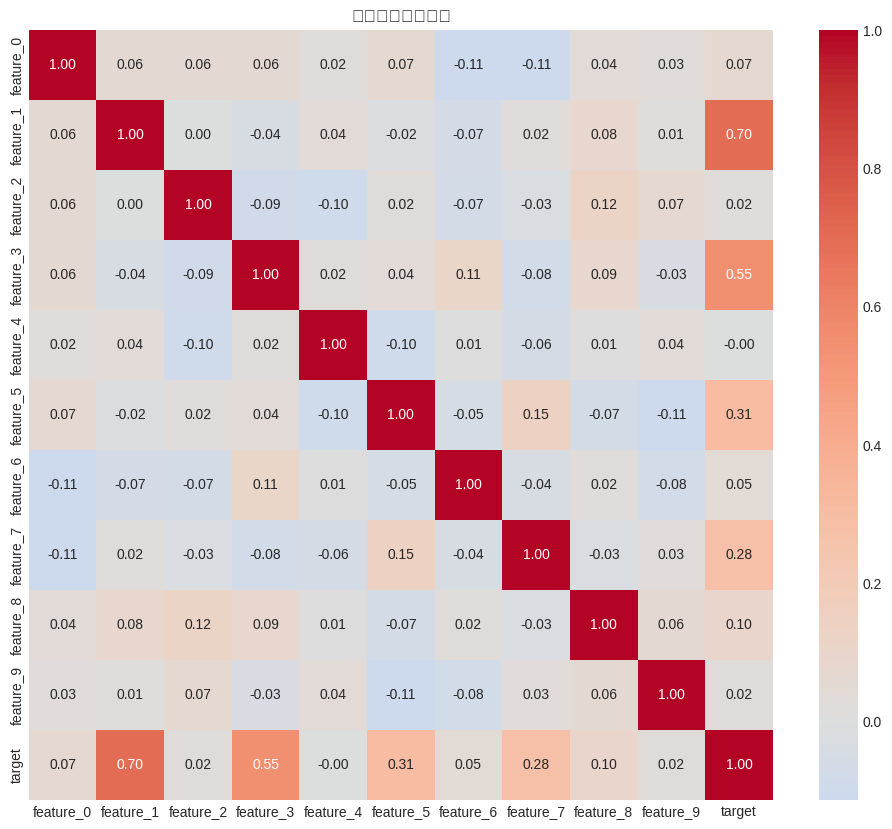

In [4]:
# 合成データ生成（10特徴量）
X_multi, y_multi = make_regression(
    n_samples=200,
    n_features=10,
    n_informative=7,  # 有用な特徴量は7つ
    noise=10,
    random_state=RANDOM_STATE
)

# DataFrameに変換
feature_names = [f'feature_{i}' for i in range(10)]
df_multi = pd.DataFrame(X_multi, columns=feature_names)
df_multi['target'] = y_multi

print("📊 データ情報:")
print(f"   サンプル数: {len(df_multi)}")
print(f"   特徴量数: {X_multi.shape[1]}")
print(f"\n最初の5行:")
display(df_multi.head())

# 相関行列
plt.figure(figsize=(12, 10))
sns.heatmap(df_multi.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('特徴量の相関行列')
plt.show()

### 3.1 訓練・テスト分割

In [5]:
# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y_multi, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"📊 データ分割:")
print(f"   訓練データ: {X_train.shape[0]} samples")
print(f"   テストデータ: {X_test.shape[0]} samples")

📊 データ分割:
   訓練データ: 160 samples
   テストデータ: 40 samples


### 3.2 基本的な線形回帰

📊 線形回帰の結果:

訓練データ:
   R²: 0.9948
   RMSE: 9.3252

テストデータ:
   R²: 0.9957
   RMSE: 9.0155


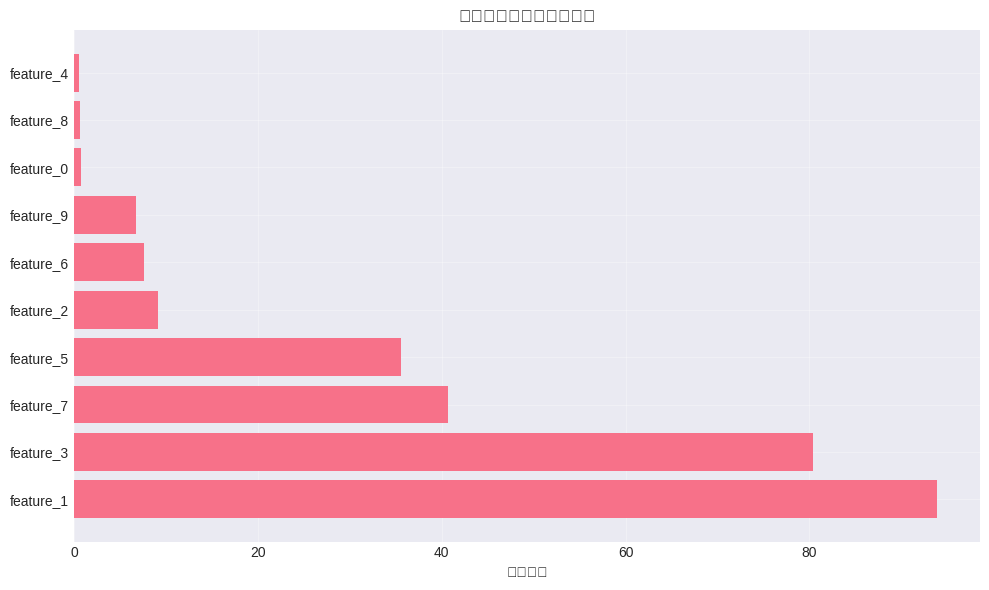

In [6]:
# 線形回帰モデル
lr = LinearRegression()
lr.fit(X_train, y_train)

# 予測
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# 評価
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("📊 線形回帰の結果:")
print(f"\n訓練データ:")
print(f"   R²: {train_r2:.4f}")
print(f"   RMSE: {train_rmse:.4f}")
print(f"\nテストデータ:")
print(f"   R²: {test_r2:.4f}")
print(f"   RMSE: {test_rmse:.4f}")

# 係数の可視化
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('係数の値')
plt.title('特徴量の重要度（係数）')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 🔨 4. 正則化: Ridge、Lasso、ElasticNet ⭐⭐⭐

### なぜ正則化が必要か？

通常の線形回帰は**過学習**しやすい問題があります：
- 特徴量が多い場合
- データが少ない場合
- ノイズが多い場合

### 正則化の種類

#### 1. Ridge回帰（L2正則化）
$$\min_{w} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} w_j^2$$

- 係数を小さくする
- すべての特徴量を保持

#### 2. Lasso回帰（L1正則化）
$$\min_{w} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |w_j|$$

- 重要でない特徴量の係数を0にする
- 特徴量選択の効果

#### 3. ElasticNet（L1+L2）
$$\min_{w} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \rho \sum_{j=1}^{p} |w_j| + \frac{\alpha(1-\rho)}{2} \sum_{j=1}^{p} w_j^2$$

- RidgeとLassoの利点を組み合わせ

### 4.1 過学習のデモ

In [7]:
# 過学習を起こしやすいデータ生成
np.random.seed(RANDOM_STATE)
n_samples_small = 50
n_features_large = 100  # 特徴量がサンプル数より多い！

X_overfit, y_overfit = make_regression(
    n_samples=n_samples_small,
    n_features=n_features_large,
    n_informative=10,
    noise=20,
    random_state=RANDOM_STATE
)

# データ分割
X_train_of, X_test_of, y_train_of, y_test_of = train_test_split(
    X_overfit, y_overfit, test_size=0.3, random_state=RANDOM_STATE
)

# 通常の線形回帰（過学習する）
lr_overfit = LinearRegression()
lr_overfit.fit(X_train_of, y_train_of)

train_score_of = lr_overfit.score(X_train_of, y_train_of)
test_score_of = lr_overfit.score(X_test_of, y_test_of)

print("⚠️ 過学習の例（サンプル数 < 特徴量数）:")
print(f"   サンプル数: {n_samples_small}")
print(f"   特徴量数: {n_features_large}")
print(f"\n通常の線形回帰:")
print(f"   訓練R²: {train_score_of:.4f}")
print(f"   テストR²: {test_score_of:.4f}")
print(f"   ⚠️ 訓練スコアは高いが、テストスコアは低い → 過学習！")

⚠️ 過学習の例（サンプル数 < 特徴量数）:
   サンプル数: 50
   特徴量数: 100

通常の線形回帰:
   訓練R²: 1.0000
   テストR²: 0.1196
   ⚠️ 訓練スコアは高いが、テストスコアは低い → 過学習！


### 4.2 Ridge回帰で過学習を防ぐ

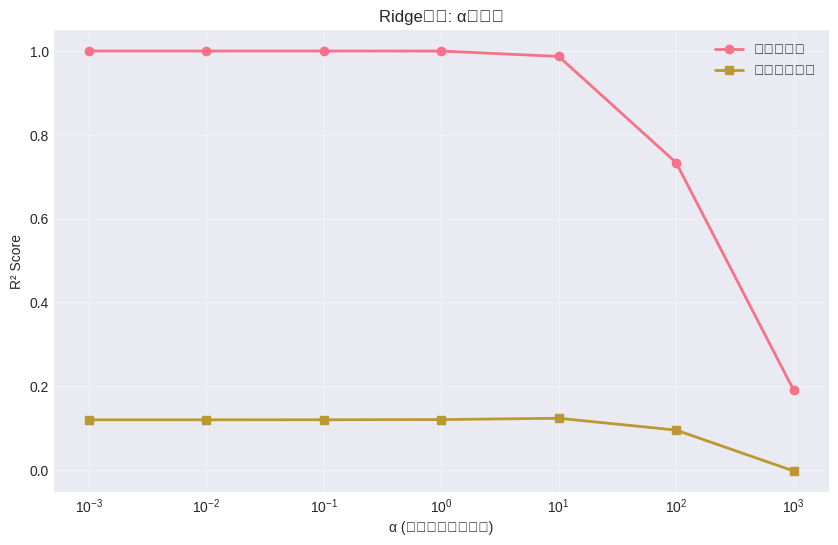


最適なα: 10
テストR²: 0.1233


In [8]:
# Ridge回帰（αを変化させる）
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores_ridge = []
test_scores_ridge = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_of, y_train_of)
    train_scores_ridge.append(ridge.score(X_train_of, y_train_of))
    test_scores_ridge.append(ridge.score(X_test_of, y_test_of))

# 可視化
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_scores_ridge, 'o-', label='訓練スコア', linewidth=2)
plt.plot(alphas, test_scores_ridge, 's-', label='テストスコア', linewidth=2)
plt.xscale('log')
plt.xlabel('α (正則化パラメータ)')
plt.ylabel('R² Score')
plt.title('Ridge回帰: αの影響')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 最適なαを見つける
best_idx = np.argmax(test_scores_ridge)
best_alpha = alphas[best_idx]
print(f"\n最適なα: {best_alpha}")
print(f"テストR²: {test_scores_ridge[best_idx]:.4f}")

### 4.3 Ridge vs Lasso vs ElasticNet の比較


📊 モデル比較:


,train_r2,test_r2,n_features
Ridge,0.987010,0.123250,100.0
Lasso,0.998256,0.924530,34.0
ElasticNet,0.962063,0.136647,90.0


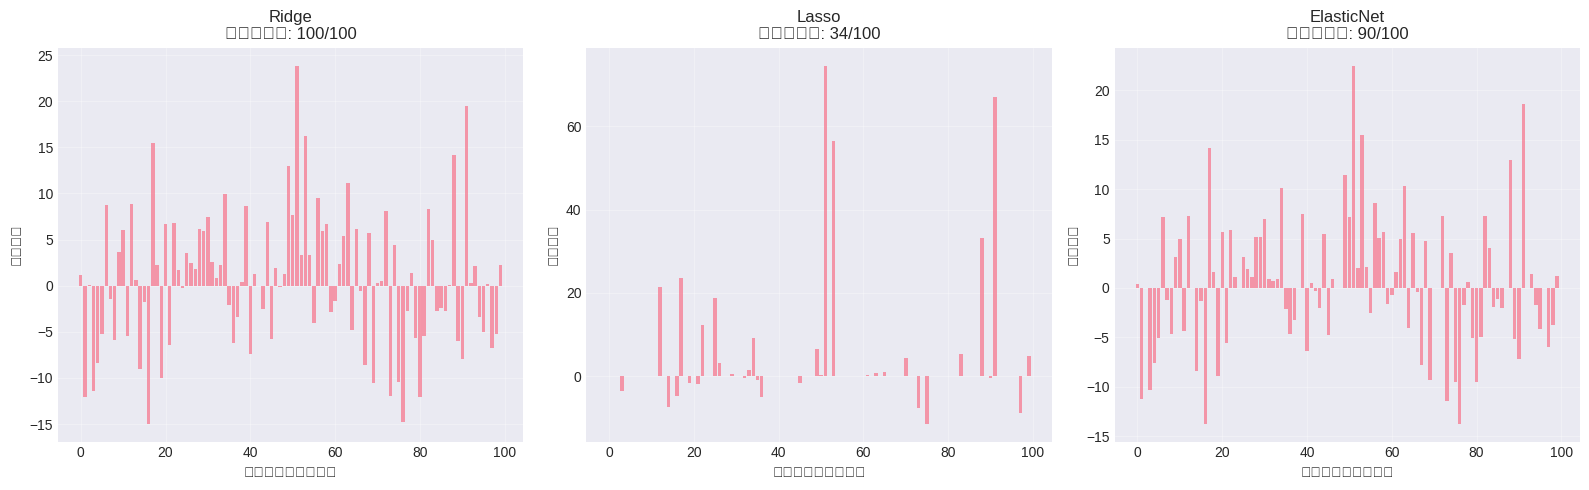


💡 ポイント:
   - Ridge: すべての特徴量を保持（係数が小さくなる）
   - Lasso: 重要でない特徴量を自動選択（係数が0になる）
   - ElasticNet: 両方の利点を組み合わせ


In [9]:
# 3つのモデルを訓練
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=1)
elastic = ElasticNet(alpha=1, l1_ratio=0.5)

models = {
    'Ridge': ridge,
    'Lasso': lasso,
    'ElasticNet': elastic
}

results = {}
for name, model in models.items():
    model.fit(X_train_of, y_train_of)
    train_score = model.score(X_train_of, y_train_of)
    test_score = model.score(X_test_of, y_test_of)
    n_nonzero = np.sum(model.coef_ != 0)
    
    results[name] = {
        'train_r2': train_score,
        'test_r2': test_score,
        'n_features': n_nonzero
    }

# 結果を表示
results_df = pd.DataFrame(results).T
print("\n📊 モデル比較:")
display(results_df)

# 係数の可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, (name, model) in zip(axes, models.items()):
    coefs = model.coef_
    ax.bar(range(len(coefs)), coefs, alpha=0.7)
    ax.set_xlabel('特徴量インデックス')
    ax.set_ylabel('係数の値')
    ax.set_title(f'{name}\n非ゼロ係数: {np.sum(coefs != 0)}/{len(coefs)}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 ポイント:")
print("   - Ridge: すべての特徴量を保持（係数が小さくなる）")
print("   - Lasso: 重要でない特徴量を自動選択（係数が0になる）")
print("   - ElasticNet: 両方の利点を組み合わせ")

## 🏠 5. 実践例: California住宅価格予測

実データで線形モデルを適用してみましょう。

🏠 Synthetic Housing Dataset (simulating California Housing)

データサイズ: (20640, 9)

特徴量:
   - MedInc
   - HouseAge
   - AveRooms
   - AveBedrms
   - Population
   - AveOccup
   - Latitude
   - Longitude

統計情報:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean      -0.004199      0.008641      0.005333     -0.006446      0.008433   
std        1.013887      1.000382      0.994928      1.005202      0.990200   
min       -4.462969     -3.655087     -3.940008     -3.999332     -4.157734   
25%       -0.685405     -0.667977     -0.664318     -0.688654     -0.657920   
50%       -0.009799      0.001382      0.007578     -0.006189      0.017309   
75%        0.680967      0.689593      0.678435      0.677467      0.673398   
max        3.976868      4.202026      3.727833      4.562115      3.926238   

           AveOccup      Latitude     Longitude         Price  
count  20640.0000

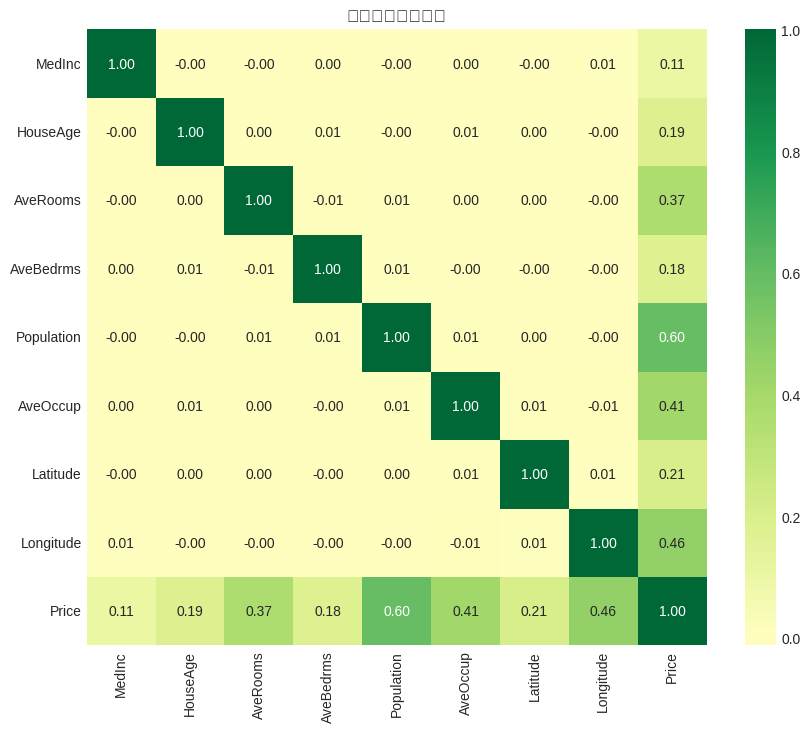

In [10]:
# Synthetic housing price dataset (simulating California Housing)
np.random.seed(RANDOM_STATE)

# Generate base regression data
X_housing, y_housing_base = make_regression(
    n_samples=20640,  # Same as California Housing
    n_features=8,
    n_informative=8,
    noise=15,
    random_state=RANDOM_STATE
)

# Scale target to realistic housing prices (in $100k units)
y_housing = (y_housing_base - y_housing_base.min()) / (y_housing_base.max() - y_housing_base.min()) * 4 + 0.5

# Feature names matching California Housing
feature_names_housing = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
    'Population', 'AveOccup', 'Latitude', 'Longitude'
]

# DataFrameに変換
df_housing = pd.DataFrame(X_housing, columns=feature_names_housing)
df_housing['Price'] = y_housing

print("🏠 Synthetic Housing Dataset (simulating California Housing)")
print(f"\nデータサイズ: {df_housing.shape}")
print(f"\n特徴量:")
for feat in feature_names_housing:
    print(f"   - {feat}")

print(f"\n統計情報:")
print(df_housing.describe())

# 相関行列
plt.figure(figsize=(10, 8))
sns.heatmap(df_housing.corr(), annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title('特徴量の相関行列')
plt.show()

### 5.1 データの前処理

In [11]:
# データ分割
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=RANDOM_STATE
)

# 標準化（重要！）
scaler = StandardScaler()
X_train_h_scaled = scaler.fit_transform(X_train_h)
X_test_h_scaled = scaler.transform(X_test_h)

print("✅ データ準備完了")
print(f"   訓練データ: {X_train_h_scaled.shape[0]} samples")
print(f"   テストデータ: {X_test_h_scaled.shape[0]} samples")
print(f"\n標準化前の統計:")
print(f"   平均: {X_train_h.mean(axis=0)[:3]}...")
print(f"   標準偏差: {X_train_h.std(axis=0)[:3]}...")
print(f"\n標準化後の統計:")
print(f"   平均: {X_train_h_scaled.mean(axis=0)[:3]}...")
print(f"   標準偏差: {X_train_h_scaled.std(axis=0)[:3]}...")

✅ データ準備完了
   訓練データ: 16512 samples
   テストデータ: 4128 samples

標準化前の統計:
   平均: [-0.00513685  0.00740688  0.00993822]...
   標準偏差: [1.01345484 0.99917379 0.99900506]...

標準化後の統計:
   平均: [ 2.66528832e-17  7.18968920e-17 -1.92197948e-17]...
   標準偏差: [1. 1. 1.]...


### 5.2 モデルの訓練と評価


📊 モデル比較結果:


,Model,Train R²,Test R²,Train RMSE,Test RMSE
0,Linear Regression,0.991684,0.991554,0.047233,0.047493
1,Ridge (α=1),0.991684,0.991554,0.047233,0.047494
2,Ridge (α=10),0.991684,0.991551,0.047234,0.047501
3,Lasso (α=0.1),0.730300,0.731941,0.268985,0.267557
4,ElasticNet,0.900771,0.900184,0.163158,0.163268


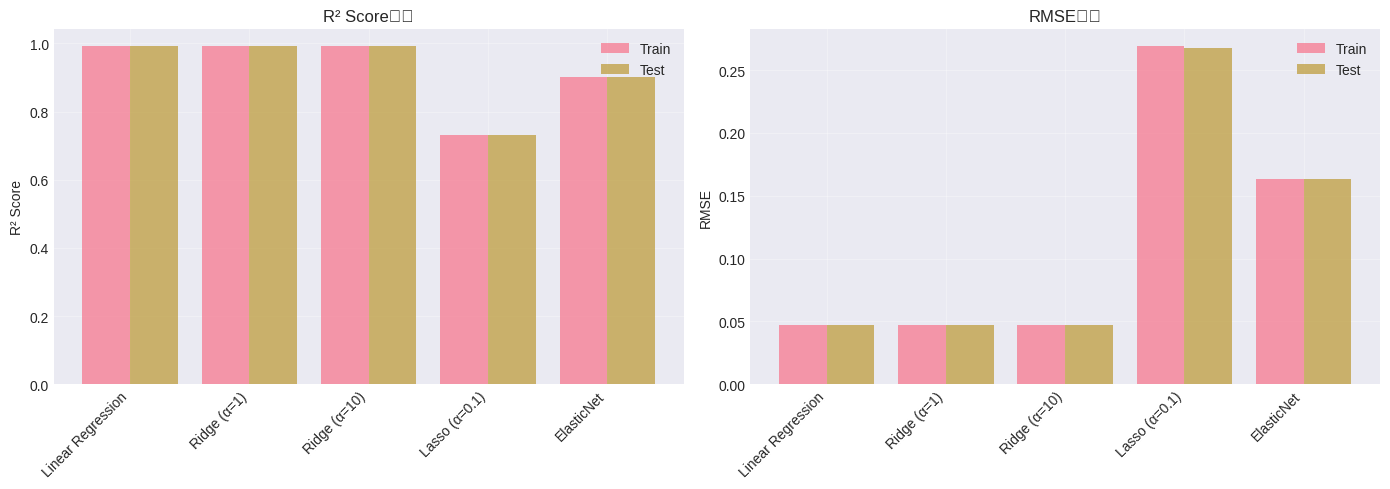

In [12]:
# 複数のモデルを訓練
models_housing = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1)': Ridge(alpha=1),
    'Ridge (α=10)': Ridge(alpha=10),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

results_housing = []

for name, model in models_housing.items():
    # 訓練
    model.fit(X_train_h_scaled, y_train_h)
    
    # 予測
    y_train_pred = model.predict(X_train_h_scaled)
    y_test_pred = model.predict(X_test_h_scaled)
    
    # 評価
    results_housing.append({
        'Model': name,
        'Train R²': r2_score(y_train_h, y_train_pred),
        'Test R²': r2_score(y_test_h, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train_h, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test_h, y_test_pred))
    })

# 結果を表示
results_housing_df = pd.DataFrame(results_housing)
print("\n📊 モデル比較結果:")
display(results_housing_df)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R²スコア
x_pos = np.arange(len(results_housing_df))
axes[0].bar(x_pos - 0.2, results_housing_df['Train R²'], 0.4, label='Train', alpha=0.7)
axes[0].bar(x_pos + 0.2, results_housing_df['Test R²'], 0.4, label='Test', alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_housing_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score比較')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].bar(x_pos - 0.2, results_housing_df['Train RMSE'], 0.4, label='Train', alpha=0.7)
axes[1].bar(x_pos + 0.2, results_housing_df['Test RMSE'], 0.4, label='Test', alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_housing_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE比較')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Cross-Validationで最適なαを探索

In [13]:
# RidgeCVで最適なαを自動的に見つける
alphas_cv = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas_cv, cv=5)
ridge_cv.fit(X_train_h_scaled, y_train_h)

print(f"\n🎯 RidgeCV結果:")
print(f"   最適なα: {ridge_cv.alpha_:.4f}")
print(f"   テストR²: {ridge_cv.score(X_test_h_scaled, y_test_h):.4f}")

# LassoCVも試す
lasso_cv = LassoCV(alphas=alphas_cv, cv=5, random_state=RANDOM_STATE)
lasso_cv.fit(X_train_h_scaled, y_train_h)

print(f"\n🎯 LassoCV結果:")
print(f"   最適なα: {lasso_cv.alpha_:.4f}")
print(f"   テストR²: {lasso_cv.score(X_test_h_scaled, y_test_h):.4f}")
print(f"   選択された特徴量数: {np.sum(lasso_cv.coef_ != 0)}/{len(lasso_cv.coef_)}")


🎯 RidgeCV結果:
   最適なα: 0.4642
   テストR²: 0.9916

🎯 LassoCV結果:
   最適なα: 0.0010
   テストR²: 0.9915
   選択された特徴量数: 8/8


### 5.4 予測の可視化

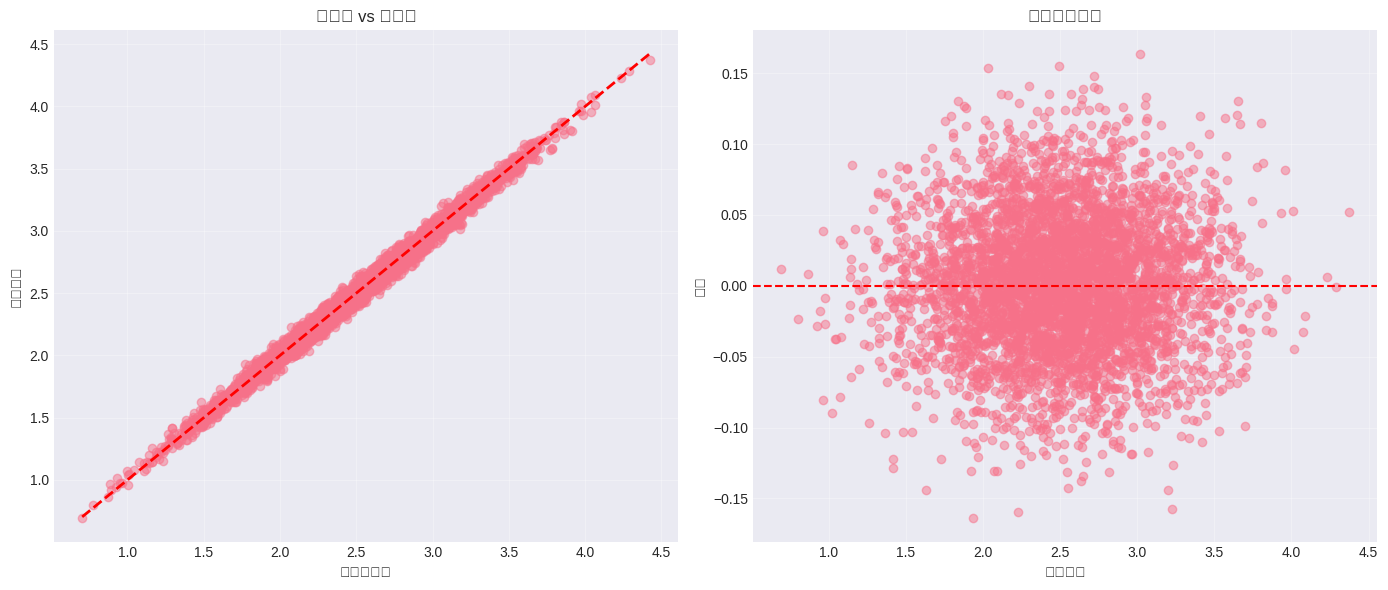

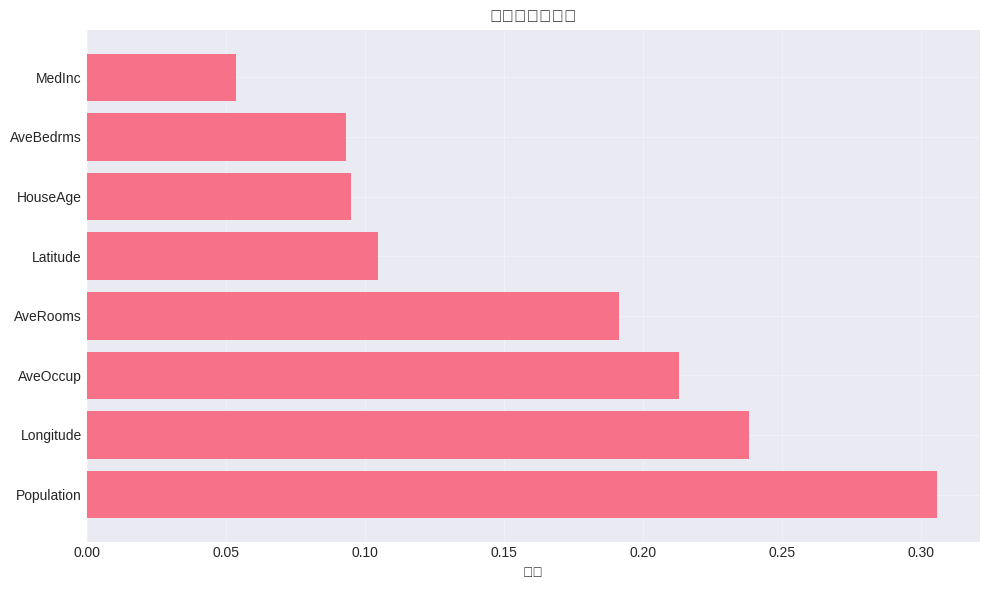


📊 特徴量の重要度:


,Feature,Coefficient
4,Population,0.305866
7,Longitude,0.238174
5,AveOccup,0.212865
2,AveRooms,0.191430
6,Latitude,0.104687
1,HouseAge,0.095094
3,AveBedrms,0.093229
0,MedInc,0.053783


In [14]:
# 最良のモデル（Ridge）で予測
best_model = ridge_cv
y_pred_final = best_model.predict(X_test_h_scaled)

# 実測値 vs 予測値
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 散布図
axes[0].scatter(y_test_h, y_pred_final, alpha=0.5)
axes[0].plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--', lw=2)
axes[0].set_xlabel('実際の価格')
axes[0].set_ylabel('予測価格')
axes[0].set_title('実測値 vs 予測値')
axes[0].grid(True, alpha=0.3)

# 残差プロット
residuals_final = y_test_h - y_pred_final
axes[1].scatter(y_pred_final, residuals_final, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('予測価格')
axes[1].set_ylabel('残差')
axes[1].set_title('残差プロット')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 特徴量の重要度
feature_importance = pd.DataFrame({
    'Feature': feature_names_housing,
    'Coefficient': best_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('係数')
plt.title('特徴量の重要度')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 特徴量の重要度:")
display(feature_importance)

## 🎓 6. まとめ

### 学んだこと

1. ✅ **線形回帰の基礎**
   - 最小二乗法による係数の推定
   - R²とRMSEによる評価
   - 残差分析

2. ✅ **正則化の重要性**
   - Ridge（L2）: 係数を小さくする
   - Lasso（L1）: 特徴量選択
   - ElasticNet: 両方の利点

3. ✅ **実践的なテクニック**
   - 特徴量の標準化
   - Cross-Validationによるα選択
   - モデルの比較と選択

### 次のステップ

- **ノートブック05**: 決定木とアンサンブルモデル
- **ノートブック06**: SVM とカーネル法

### 重要なポイント

💡 **いつ線形モデルを使うべきか？**
- データが線形関係に従う場合
- 解釈性が重要な場合
- 計算速度が必要な場合
- ベースラインモデルとして

⚠️ **線形モデルの限界**
- 非線形な関係をモデル化できない
- 特徴量エンジニアリングが必要
- 外れ値に敏感

---

**🎉 お疲れ様でした！線形モデルの基礎から実践までマスターしました！**

## 📝 練習問題

### 問題1: 基礎知識
1. Ridge回帰とLasso回帰の違いを説明してください
2. 正則化パラメータαを大きくすると何が起こりますか？
3. なぜ特徴量の標準化が重要ですか？

### 問題2: 実装
1. California Housingデータで、PolynomialFeaturesを使って多項式回帰を実装してください
2. GridSearchCVを使って、ElasticNetの最適なαとl1_ratioを見つけてください

### 問題3: 発展
1. 独自のデータセット（UCI MLRepositoryなど）で線形モデルを適用してください
2. 正則化パスをプロットして、どの特徴量が重要か分析してください

---

## 🔗 参考リンク

- [scikit-learn Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)
- [Ridge Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [Lasso Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

---

**Happy Learning! 📈**